In [56]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from pandas import DataFrame
from math import sqrt

In [57]:
# The path to our CSV file
file = "../data/csv/Gold_Data.csv"
df = pd.read_csv(file)
df.head()

,Business_Week,Gold_Change,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Date,Open Interest,Money Manager Shorts,Money Manager Longs,Ten_Yr_Futures_Change,...,USD_Change,USD_Settle,USD_Volume,USD_Wave,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,ZAR_Volume,ZAR_Wave,ZAR_Prev. Day Open Interest
0,"[2006-06-07, 2006-06-13]",0.0,602.80,324.800000,189517.8,2006-06-13,382474.0,30916.0,103211.0,0.0,...,1.760,85.7620,7364.2,NaN,38753.4,0.0760,6.7790,65.00,NaN,2332.40
1,"[2006-06-14, 2006-06-20]",0.0,570.50,78.400000,191302.8,2006-06-20,390281.0,30963.0,94632.0,0.0,...,0.013,86.2112,772.6,NaN,37679.6,0.1175,6.9283,45.00,NaN,2276.80
2,"[2006-06-21, 2006-06-27]",0.0,584.18,51.800000,189599.0,2006-06-27,384321.0,32287.0,91042.0,0.0,...,0.340,86.0000,5056.2,NaN,23433.4,0.1715,7.4125,359.25,NaN,2395.75
3,"[2006-06-28, 2006-07-04]",0.0,594.40,31923.666667,297778.0,2006-07-03,392868.0,30452.0,92545.0,0.0,...,-1.300,85.2640,2935.2,NaN,19682.8,-0.2920,7.1685,35.60,NaN,2007.00
4,"[2006-07-05, 2006-07-11]",0.0,634.00,43180.200000,253799.8,2006-07-11,427008.0,27624.0,104213.0,0.0,...,0.230,85.0220,2823.0,NaN,19415.6,0.0960,7.1820,186.20,NaN,2227.00


In [58]:
#new = old.filter(['A','B','D'], axis=1)

df1 = df.filter(['Date','Gold_Settle','Open Interest','Ten_Yr_Futures_Settle','ZAR_Settle','Money Manager Shorts', 'Money Manager Longs'], axis=1)

In [59]:
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

In [60]:
df1.head()

,Gold_Settle,Open Interest,Ten_Yr_Futures_Settle,ZAR_Settle,Money Manager Shorts,Money Manager Longs
Date,,,,,,
2006-06-13,602.80,382474.0,105.86250,6.7790,30916.0,103211.0
2006-06-20,570.50,390281.0,105.01875,6.9283,30963.0,94632.0
2006-06-27,584.18,384321.0,104.33125,7.4125,32287.0,91042.0
2006-07-03,594.40,392868.0,104.53125,7.1685,30452.0,92545.0
2006-07-11,634.00,427008.0,104.71250,7.1820,27624.0,104213.0


In [61]:
df1.corr()

,Gold_Settle,Open Interest,Ten_Yr_Futures_Settle,ZAR_Settle,Money Manager Shorts,Money Manager Longs
Gold_Settle,1.000000,0.716232,0.831606,0.170779,0.029869,0.344567
Open Interest,0.716232,1.000000,0.564668,0.235755,0.036690,0.655936
Ten_Yr_Futures_Settle,0.831606,0.564668,1.000000,0.417406,0.114371,0.275529
ZAR_Settle,0.170779,0.235755,0.417406,1.000000,0.635832,0.015022
Money Manager Shorts,0.029869,0.036690,0.114371,0.635832,1.000000,-0.444781
Money Manager Longs,0.344567,0.655936,0.275529,0.015022,-0.444781,1.000000


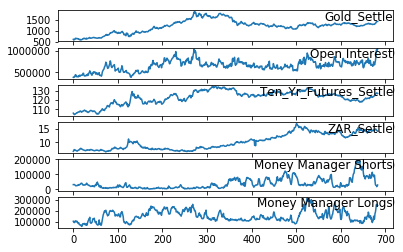

In [62]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [63]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.025239   0.000000   0.049918   0.019160   0.158664   0.181376  0.000000
2   0.000000   0.011897   0.022412   0.033710   0.158911   0.148317  0.010690
3   0.010690   0.002815   0.000000   0.080899   0.165892   0.134482  0.018676
4   0.018676   0.015839   0.006520   0.057119   0.156217   0.140274  0.049619
5   0.049619   0.067864   0.012429   0.058435   0.141308   0.185238  0.062903


In [64]:

# split into train and test sets
values = reframed.values
n_train_days = int(len(df1)*.7)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(478, 1, 6) (478,) (205, 1, 6) (205,)


Train on 478 samples, validate on 205 samples
Epoch 1/100
 - 2s - loss: 0.2480 - val_loss: 0.0651
Epoch 2/100
 - 0s - loss: 0.1490 - val_loss: 0.1313
Epoch 3/100
 - 0s - loss: 0.1417 - val_loss: 0.1313
Epoch 4/100
 - 0s - loss: 0.1363 - val_loss: 0.1101
Epoch 5/100
 - 0s - loss: 0.1189 - val_loss: 0.1041
Epoch 6/100
 - 0s - loss: 0.1029 - val_loss: 0.0992
Epoch 7/100
 - 0s - loss: 0.0857 - val_loss: 0.0920
Epoch 8/100
 - 0s - loss: 0.0656 - val_loss: 0.0872
Epoch 9/100
 - 0s - loss: 0.0562 - val_loss: 0.0832
Epoch 10/100
 - 0s - loss: 0.0530 - val_loss: 0.0770
Epoch 11/100
 - 0s - loss: 0.0485 - val_loss: 0.0695
Epoch 12/100
 - 0s - loss: 0.0454 - val_loss: 0.0614
Epoch 13/100
 - 0s - loss: 0.0431 - val_loss: 0.0537
Epoch 14/100
 - 0s - loss: 0.0405 - val_loss: 0.0526
Epoch 15/100
 - 0s - loss: 0.0374 - val_loss: 0.0517
Epoch 16/100
 - 0s - loss: 0.0350 - val_loss: 0.0533
Epoch 17/100
 - 0s - loss: 0.0321 - val_loss: 0.0482
Epoch 18/100
 - 0s - loss: 0.0307 - val_loss: 0.0498
Epoch 19/

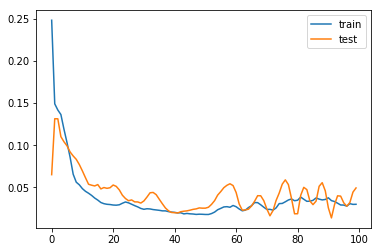

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [66]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [67]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 76.095


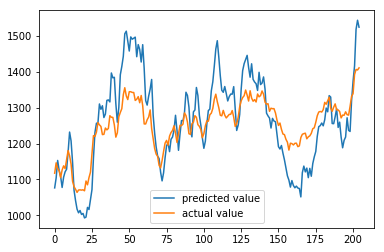

In [68]:
pyplot.plot(inv_yhat, label="predicted value")
pyplot.plot(inv_y, label="actual value")
pyplot.legend()
pyplot.show()

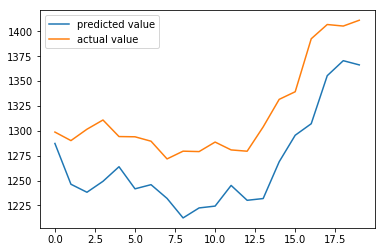

In [55]:
pyplot.plot(inv_yhat[-20:], label="predicted value")
pyplot.plot(inv_y[-20:], label="actual value")
pyplot.legend()
pyplot.show()